# Virtual Neuron example

In this example we set up a larger network of neurons, then the network is modified so that only a few core neurons remain normal, while the rest of the population is changed to be virtual neurons. Virtual neurons are not simulated, instead their activity is represented by data read from file. All the synapses in the network remain though. This allows the user to simulate a subset of the network, but retaining the full input those neurons should have received if all the neurons had been simulated normally.

In [1]:
import os
import numpy as np

number_of_neurons = 100
num_sim_neurons = 20
network_path = os.path.join("networks","virtual_network_example")
modified_network_file = os.path.join(network_path, "modified-network.hdf5")

%matplotlib inline


## Start ipcluster

For larger networks it can be helpful to run the network creation code in parallel. You can start the ipyparallel workers using ```start_ipcluster.sh``` located in the ```examples/notebook``` directory. After starting ipcluster give it a few seconds to startup before proceeding with the rest of the commands in this notebook. To stop the cluster use ```ipcluster stop```.

For instructions how to install and activate ipyparallel for your notebook see https://github.com/ipython/ipyparallel

If you just want to run the notebook in serial, then you do not have to do anything extra. The code automatically detects if ipyparallel is running.

## Check if ipyparallel is running and set ```SNUDDA_DATA```

In [2]:
from ipyparallel import Client
import snudda

os.environ["IPYTHONDIR"] = ".ipython"
os.environ["IPYTHON_PROFILE"] = "default"

u_file = os.path.join(".ipython", "profile_default", "security", "ipcontroller-client.json")
if os.path.exists(u_file):
    rc = Client(url_file=u_file, timeout=120, debug=False)
else:
    print("Warning, running in serial.")
    rc = None

# Check if the user has the updated BasalGangliaData installed, if not use the old data provided
bg_path = "../../../../BasalGangliaData/data/"
if os.path.isdir(bg_path) and False:
    snudda_data = bg_path
else:
    snudda_data = os.path.join(os.path.dirname(snudda.__file__), "data")

Warning, running in serial.


In [3]:
snudda_data

'/home/hjorth/HBP/Snudda/snudda/data'

In [4]:
import os
from snudda import SnuddaInit

si = SnuddaInit(network_path=network_path, random_seed=12345, snudda_data=snudda_data)
si.define_striatum(num_dSPN=np.ceil(number_of_neurons/2), num_iSPN=np.ceil(number_of_neurons/2), num_FS=0, num_LTS=0, num_ChIN=0,
                    volume_type="cube", neurons_dir="$DATA/neurons")
si.write_json()

Using cube for striatum
Neurons for striatum read from /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum
Adding neurons: dSPN from dir /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/dspn
Adding neurons: iSPN from dir /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/ispn
Writing networks/virtual_network_example/network-config.json


In [5]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path)
sp.place()

Reading SNUDDA_DATA=/home/hjorth/HBP/Snudda/snudda/data from networks/virtual_network_example/network-config.json


In [6]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path, rc=rc)
sd.detect()

Reading SNUDDA_DATA=/home/hjorth/HBP/Snudda/snudda/data from networks/virtual_network_example/network-config.json
No d_view specified, running distribute neurons in serial
Processing hyper voxel : 21/64 (100 neurons)
Processing hyper voxel : 5/64 (94 neurons)
Processing hyper voxel : 17/64 (93 neurons)
Processing hyper voxel : 20/64 (83 neurons)
Processing hyper voxel : 22/64 (66 neurons)
Processing hyper voxel : 1/64 (64 neurons)
Processing hyper voxel : 37/64 (54 neurons)
Processing hyper voxel : 25/64 (52 neurons)
Processing hyper voxel : 16/64 (50 neurons)
Processing hyper voxel : 4/64 (44 neurons)
Processing hyper voxel : 6/64 (35 neurons)
Processing hyper voxel : 18/64 (34 neurons)
Processing hyper voxel : 33/64 (29 neurons)
Processing hyper voxel : 0/64 (19 neurons)
Processing hyper voxel : 9/64 (19 neurons)
Processing hyper voxel : 24/64 (10 neurons)
Processing hyper voxel : 26/64 (9 neurons)
Processing hyper voxel : 2/64 (9 neurons)
Processing hyper voxel : 38/64 (9 neurons)
P

In [7]:
from snudda import SnuddaPrune

sp = SnuddaPrune(network_path=network_path, rc=rc)
sp.prune()

Read 159333 out of total 159333 synapses


In [8]:
if number_of_neurons <= 50:
    # Do not plot too large networks, as that will take a really long time
    from snudda.plotting import PlotNetwork
    pn = PlotNetwork(network_path)
    pn.plot()
    pn.close()

# Converting neurons to virtual neurons

We want to simulate the centre neurons, all other neurons are changed into virtual neurons.

In [9]:
from snudda.utils.ablate_network import SnuddaAblateNetwork
from snudda.utils import SnuddaLoad

sa = SnuddaAblateNetwork(network_file=network_path)
sl = sa.snudda_load
virtual_idx = sorted(list(set(sl.iter_neuron_id()) - set([x for x,_ in sl.get_centre_neurons_iterator(n_neurons=num_sim_neurons)])))

sa.make_virtual(virtual_idx)
sa.write_network(modified_network_file)

Loading 100 neurons with 7744 synapses and 0 gap junctions
Writing to networks/virtual_network_example/modified-network.hdf5
Copying morphologies
Keeping 100 neurons.
Making neuron id 0 (dSPN_3) virtual (old ID 0)
Making neuron id 1 (dSPN_2) virtual (old ID 1)
Making neuron id 2 (dSPN_3) virtual (old ID 2)
Making neuron id 3 (dSPN_0) virtual (old ID 3)
Making neuron id 4 (iSPN_3) virtual (old ID 4)
Making neuron id 5 (iSPN_2) virtual (old ID 5)
Making neuron id 6 (dSPN_1) virtual (old ID 6)
Making neuron id 7 (dSPN_0) virtual (old ID 7)
Making neuron id 8 (dSPN_0) virtual (old ID 8)
Making neuron id 9 (iSPN_3) virtual (old ID 9)
Making neuron id 11 (dSPN_1) virtual (old ID 11)
Making neuron id 12 (dSPN_0) virtual (old ID 12)
Making neuron id 13 (dSPN_2) virtual (old ID 13)
Making neuron id 14 (iSPN_3) virtual (old ID 14)
Making neuron id 15 (iSPN_3) virtual (old ID 15)
Making neuron id 17 (iSPN_2) virtual (old ID 17)
Making neuron id 18 (dSPN_1) virtual (old ID 18)
Making neuron id 20 

# Generate the input for the neurons, and the activity of the virtual neurons

In the ```"dSPN"``` and ```"iSPN"``` blocks we have added an ```"activity"``` field, which is used for the neurons that are turned into virtual neurons of that type.

```
	"VirtualNeuron" : {
	    "spikeFile": "virtual_input_spikes.txt",
	    "rowMappingFile": "virtual_input__mapping.txt"
	}	
```

In [10]:
from snudda.input.virtual_input import VirtualInput
vi = VirtualInput(spike_file="virtual_input_spikes.txt", mapping_file="virtual_input_mapping.txt")

for vidx in virtual_idx:
    vi.add_input(neuron_id=vidx, spike_times = vi.poisson_spikes(frequency=5, max_time=5))
    
vi.write_data()

Important that we remember to use the modified network file for the input generation.

In [11]:
from snudda.input import SnuddaInput
sin = SnuddaInput(network_path=network_path, hdf5_network_file=modified_network_file, rc=rc, input_config_file="virtual-input.json")
sin.generate()

Reading SNUDDA_DATA=/home/hjorth/HBP/Snudda/snudda/data from networks/virtual_network_example/network-config.json
Loading 100 neurons with 7744 synapses and 0 gap junctions
Writing spikes to networks/virtual_network_example/input-spikes.hdf5


In [12]:
cmd_str = f"nrnivmodl {snudda_data}/neurons/mechanisms"
print(cmd_str)
os.system(cmd_str)

nrnivmodl /home/hjorth/HBP/Snudda/snudda/data/neurons/mechanisms
/home/hjorth/HBP/Snudda/examples/notebooks/VirtualNeurons
Mod files: "/home/hjorth/HBP/Snudda/snudda/data/neurons/mechanisms//home/hjorth/HBP/Snudda/snudda/data/neurons/mechanisms/bk_ch.mod" "/home/hjorth/HBP/Snudda/snudda/data/neurons/mechanisms//home/hjorth/HBP/Snudda/snudda/data/neurons/mechanisms/bk_fs.mod" "/home/hjorth/HBP/Snudda/snudda/data/neurons/mechanisms//home/hjorth/HBP/Snudda/snudda/data/neurons/mechanisms/bk_ms.mod" "/home/hjorth/HBP/Snudda/snudda/data/neurons/mechanisms//home/hjorth/HBP/Snudda/snudda/data/neurons/mechanisms/ca_ch.mod" "/home/hjorth/HBP/Snudda/snudda/data/neurons/mechanisms//home/hjorth/HBP/Snudda/snudda/data/neurons/mechanisms/cadyn_fs.mod" "/home/hjorth/HBP/Snudda/snudda/data/neurons/mechanisms//home/hjorth/HBP/Snudda/snudda/data/neurons/mechanisms/cadyn_ms.mod" "/home/hjorth/HBP/Snudda/snudda/data/neurons/mechanisms//home/hjorth/HBP/Snudda/snudda/data/neurons/mechanisms/cal12_ms.mod" "/h

0

In [13]:
from snudda.simulate import SnuddaSimulate
sim = SnuddaSimulate(network_file=modified_network_file, network_path=network_path)
sim.setup()
sim.add_external_input()
sim.add_volt_recording_soma()
sim.run(500)  # 100 ms
sim.write_output()

Reading SNUDDA_DATA=/home/hjorth/HBP/Snudda/snudda/data from networks/virtual_network_example/network-config.json
Loading 100 neurons with 7744 synapses and 0 gap junctions
Empty modFile field for ChIN -> dSPN synapses. This channel is IGNORED.
Empty modFile field for ChIN -> iSPN synapses. This channel is IGNORED.
Warning! No modulation key specified, ignoring /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/dspn/str-dspn-e150917_c6_D1-m21-6-DE-v20190503/modulation.json
Warning! No modulation key specified, ignoring /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/ispn/str-ispn-e150917_c11_D2-mWT-MSN1-v20190603/modulation.json
Warning! No modulation key specified, ignoring /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/dspn/str-dspn-e150602_c1_D1-mWT-0728MSN01-v20190508/modulation.json
Warning! No modulation key specified, ignoring /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/dspn/str-dspn-e150602_c1_D1-mWT-0728MSN01-v20190508/modulation.json
Warning! No modulati

In [14]:
from snudda.utils import SnuddaLoad
from snudda.utils import SnuddaLoadNetworkSimulation

sl = SnuddaLoad(modified_network_file)

sim_file = os.path.join(network_path, "simulation", "output.hdf5")

sls = SnuddaLoadNetworkSimulation(network_simulation_output_file=sim_file)

Loading 100 neurons with 7744 synapses and 0 gap junctions
Loading networks/virtual_network_example/simulation/output.hdf5
Failed sanity check on neuron ID, not all neurons simulated? [10 16 19 24 25 26 27 29 35 36 37 39 41 49 50 56 57 65 71 76]


Loading network info from networks/virtual_network_example/modified-network.hdf5
Loading 100 neurons with 7744 synapses and 0 gap junctions
Loading input info from networks/virtual_network_example/input-spikes.hdf5
Loading networks/virtual_network_example/simulation/output.hdf5
Failed sanity check on neuron ID, not all neurons simulated? [10 16 19 24 25 26 27 29 35 36 37 39 41 49 50 56 57 65 71 76]
Plotting traces: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
Plotted 100 traces (total 20)
Saving to figure /home/hjorth/HBP/Snudda/examples/notebooks/VirtualNeurons/networks/virtual_network_example/figures/Network-voltage-trace--dSPN-iSPN.pdf


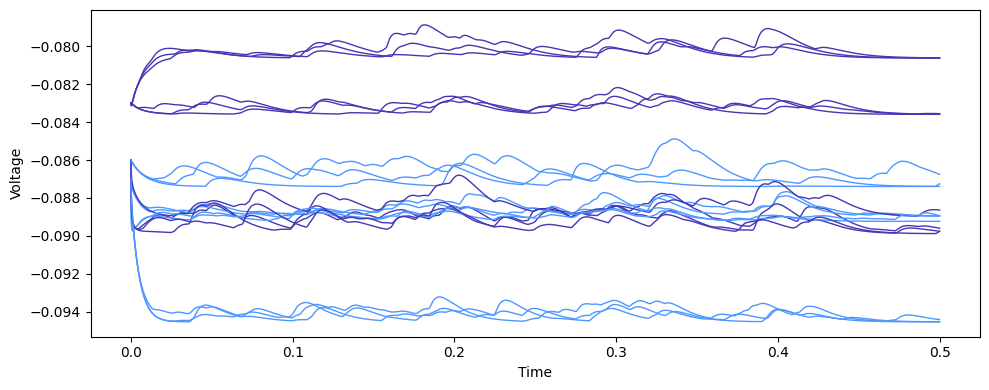

In [15]:
%matplotlib inline

from snudda.plotting.plot_traces import PlotTraces
pt = PlotTraces(output_file=sim_file, network_file=modified_network_file)
# Use trace_id to specify which traces
ax = pt.plot_traces(offset=0, time_range=(0,1.0),fig_size=(10,4))